<a href="https://colab.research.google.com/github/lordfarquadd/net-runner-ios/blob/master/Copy_of_tensorio_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Keras CIFAR-10 MobileNet Estimator Example

MobileNet model exported for both prediction on training on device with tensor/io. Wraps the keras model in an estimator and uses the experimental_mode parameter to export for training. Relies on some compat.v1 apis for optimization and loss functions.

Based on:

- https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub
- https://www.tensorflow.org/tutorials/images/transfer_learning
- https://www.tensorflow.org/guide/migrate#estimators

And really based on our Tensor/IO example at:

https://github.com/doc-ai/tensorio/tree/master/examples/notebooks/tf_2_2/keras_cifar10_mobilenet_estimator


In [ ]:
import os
import math
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

import PIL.Image as Image
import matplotlib.pylab as plt

%matplotlib inline

In [ ]:
# Runtime: Change Runtime Type

print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.4.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## CIFAR-10

Load and prepare the dataset for use with a 96x96x3 MobileNet model. We will need to upscale the 32x32 CIFAR images and normalize their pixel values to a range of `[0,1]`.

Notice that we are also severely restricting the size of the training and test sets to accommodate memory limitations in Colab.

In [ ]:
fashion_mnist = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

170500096/170498071 [==============================] - 3s 0us/step


In [ ]:
class_names = [
    'airplane', 
    'automobile', 
    'bird', 
    'cat', 
    'deer', 
    'dog', 
    'frog', 
    'horse', 
    'ship', 
    'truck'
]

In [ ]:
# We are significantly artifially constraining the size of the dataset
# due to kaggle notebook limitations

TRAIN_SIZE=2000 # Contains 50,000 images
TEST_SIZE=1000  # Contains 10,000 images

rng = np.random.default_rng()

train_indices = rng.choice(len(train_images), TRAIN_SIZE, replace=False)
train_images = train_images[train_indices]
train_labels = train_labels[train_indices]

test_indices = rng.choice(len(test_images), TEST_SIZE, replace=False)
test_images = test_images[test_indices]
test_labels = test_labels[test_indices]

print( "Training Images:", train_images.shape, train_labels.shape )
print( "Test Images:", test_images.shape, test_labels.shape )

Training Images: (2000, 32, 32, 3) (2000, 1)
Test Images: (1000, 32, 32, 3) (1000, 1)


In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
train_images = tf.image.resize(
    train_images, 
    (96,96),
    antialias=True
)

train_images = train_images.numpy()

test_images = tf.image.resize(
    test_images, 
    (96,96),
    antialias=True
)

test_images = test_images.numpy()

In [ ]:
print( train_images.shape, test_images.shape )

(2000, 96, 96, 3) (1000, 96, 96, 3)


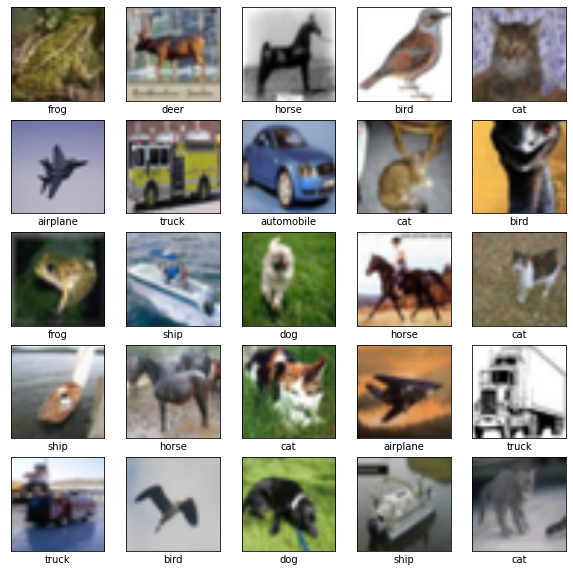

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## The Estimator

In [ ]:
TRAINING_MODEL_DIR='./checkpoints'

In [ ]:
TF_HUB_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/classification/4"
    # Use version /2 of the model for 1.13 compatibility

def make_model(base_model_trainable=False):
    model = tf.keras.Sequential([
        hub.KerasLayer(TF_HUB_URL, input_shape=(96,96,3), trainable=base_model_trainable),
        tf.keras.layers.Dense(10)
    ])
    return model

In [ ]:
# The input function is responsible for feeding data to the estimator

def input_fn(features, labels, batch_size=64, shuffle=True, num_epochs=None):
    BUFFER_SIZE = 256
    
    # 2GB limit
    dataset = tf.data.Dataset.from_tensor_slices( (features, labels) )
    
    def scale(image, label):
        # images were scaled prior to displaying them
        # image = tf.cast(image, tf.float32)
        # image /= 255
        return {'image': image}, label # label[..., tf.newaxis]
    
    dataset = dataset.map(scale)
    
    if shuffle:
      dataset = dataset.shuffle(BUFFER_SIZE) # reshuffle_each_iteration=True

    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat(num_epochs) 

    return dataset

In [ ]:
# set base_model_trainable=False for 1.13 compatibility

def model_fn(features, labels, mode):
    training = (mode == tf.estimator.ModeKeys.TRAIN)
    model = make_model(base_model_trainable=True)
    
    predictions = model(features['image'], training=training)

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(
            mode=mode, 
            predictions=predictions
        )
    
    # 1) 
    # Note this check for labels is None and then acquiring it from the features
    # This is necessary when exporting the model for training
    
    if labels is None:
        labels = features['label']
        # labels = labels[..., tf.newaxis]
    
    optimizer = tf.compat.v1.train.AdamOptimizer()
    
    # SparseCategoricalCrossentropy takes integer labels (indices) while CategoricalCrossentropy 
    # takes one-hot encodings
    
    loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
    reg_losses = model.get_losses_for(None) + model.get_losses_for(features)
    total_loss = loss_fn(labels, predictions) + tf.math.add_n(reg_losses)
    
    # 2)
    # Note we name this total loss op via a tf.identity op, allowing us to access it
    # by name in the session API on device. We'll see this name used in the model.json
    
    total_loss = tf.identity(total_loss, name='total_loss')

    accuracy = tf.compat.v1.metrics.accuracy(
        labels=labels,
        predictions=tf.math.argmax(predictions, axis=1),
        name='acc_op')

    update_ops = model.get_updates_for(None) + model.get_updates_for(features)
    
    minimize_op = optimizer.minimize(
        total_loss,
        var_list=model.trainable_variables,
        global_step=tf.compat.v1.train.get_or_create_global_step())
      
    # 3)
    # Note that we explicitly name this grouping operation, effectively giving us a way
    # to execute the minimize op above via the session api. Often we can just name the
    # minimize op directly
    
    train_op = tf.group(minimize_op, update_ops, name='train')

    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=predictions,
        loss=total_loss,
        train_op=train_op, 
        eval_metric_ops={'accuracy': accuracy}
    )

In [ ]:
BATCH_SIZE = 64
NUM_EPOCHS = 10

STEPS_PER_EPOCH = math.ceil(TRAIN_SIZE/BATCH_SIZE)
TRAINING_STEPS = STEPS_PER_EPOCH * NUM_EPOCHS

train_spec = tf.estimator.TrainSpec(
    input_fn=lambda:input_fn(train_images, train_labels, batch_size=BATCH_SIZE),
    max_steps=TRAINING_STEPS
    )

eval_spec = tf.estimator.EvalSpec(
    input_fn=lambda:input_fn(test_images, test_labels, batch_size=BATCH_SIZE, shuffle=False, num_epochs=1),
    steps=None, # STEPS_PER_EPOCH
    throttle_secs=3600
    )

In [ ]:
!rm -r './checkpoints'

rm: cannot remove './checkpoints': No such file or directory


In [ ]:
print("Running", NUM_EPOCHS, 'epochs with', STEPS_PER_EPOCH, "steps per epoch for", TRAINING_STEPS, "total training steps")

estimator = tf.estimator.Estimator(model_fn=model_fn, model_dir=TRAINING_MODEL_DIR)
tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

Running 10 epochs with 32 steps per epoch for 320 total training steps
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './checkpoints', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorfl

INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into ./checkpoints/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into ./checkpoints/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 3.6872125, step = 0


INFO:tensorflow:loss = 3.6872125, step = 0


INFO:tensorflow:global_step/sec: 6.00753


INFO:tensorflow:global_step/sec: 6.00753


INFO:tensorflow:loss = 1.5116789, step = 100 (16.647 sec)


INFO:tensorflow:loss = 1.5116789, step = 100 (16.647 sec)


INFO:tensorflow:global_step/sec: 8.50506


INFO:tensorflow:global_step/sec: 8.50506


INFO:tensorflow:loss = 0.25762147, step = 200 (11.763 sec)


INFO:tensorflow:loss = 0.25762147, step = 200 (11.763 sec)


INFO:tensorflow:global_step/sec: 8.4556


INFO:tensorflow:global_step/sec: 8.4556


INFO:tensorflow:loss = 0.70822173, step = 300 (11.823 sec)


INFO:tensorflow:loss = 0.70822173, step = 300 (11.823 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 320...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 320...


INFO:tensorflow:Saving checkpoints for 320 into ./checkpoints/model.ckpt.


INFO:tensorflow:Saving checkpoints for 320 into ./checkpoints/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 320...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 320...


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-13T22:39:21Z


INFO:tensorflow:Starting evaluation at 2021-01-13T22:39:21Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt-320


INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt-320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 6.12791s


INFO:tensorflow:Inference Time : 6.12791s


INFO:tensorflow:Finished evaluation at 2021-01-13-22:39:27


INFO:tensorflow:Finished evaluation at 2021-01-13-22:39:27


INFO:tensorflow:Saving dict for global step 320: accuracy = 0.714, global_step = 320, loss = 2.3164423


INFO:tensorflow:Saving dict for global step 320: accuracy = 0.714, global_step = 320, loss = 2.3164423


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 320: ./checkpoints/model.ckpt-320


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 320: ./checkpoints/model.ckpt-320


INFO:tensorflow:Loss for final step: 0.6873151.


INFO:tensorflow:Loss for final step: 0.6873151.


({'accuracy': 0.714, 'global_step': 320, 'loss': 2.3164423}, [])


## Export Model for Prediction

We'll use the save_model function below to export for both training and prediction


In [ ]:
# Read below for why we must disable this option before saving the model

tf.config.optimizer.set_experimental_options({
    'remapping': False
})

In [ ]:
# Set to True to inspect pbtext version of graph for debugging

SAVE_AS_TEXT=False

In [ ]:
def save_model(model_dir, output_dir, serving_input_receiver_fn, mode=tf.estimator.ModeKeys.PREDICT):
    
    estimator = tf.estimator.Estimator(
        model_fn=model_fn,
        model_dir=model_dir
    )
    
    estimator.export_saved_model(
        output_dir,
        lambda:serving_input_receiver_fn(),
        as_text=SAVE_AS_TEXT,
        experimental_mode=mode
    )


In [ ]:
# The serving input receiver function establishes the signature definitions
# for our exported model

def serving_input_predict_receiver_fn():
    image_shape = [None, 96, 96, 3]
    
    inputs = {
        'image': tf.compat.v1.placeholder(tf.float32, shape=image_shape, name='image')
    }
    
    return tf.estimator.export.ServingInputReceiver(inputs, inputs)

In [ ]:
EXPORT_MODEL_DIR='./keras-cifar10-mobilenet-estimator-predict'
!rm -r './keras-cifar10-mobilenet-estimator-predict'

rm: cannot remove './keras-cifar10-mobilenet-estimator-predict': No such file or directory


In [ ]:
save_model(TRAINING_MODEL_DIR, EXPORT_MODEL_DIR, serving_input_predict_receiver_fn)

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': './checkpoints', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': './checkpoints', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt-320


INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt-320


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: ./keras-cifar10-mobilenet-estimator-predict/temp-1610577582/saved_model.pb


INFO:tensorflow:SavedModel written to: ./keras-cifar10-mobilenet-estimator-predict/temp-1610577582/saved_model.pb


### Results

In [ ]:
# Set the trailing model id to the value produced by the exporter

PREDICT_MODEL_ID=1610577582
!saved_model_cli show --all --dir ./keras-cifar10-mobilenet-estimator-predict/1610577582


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 96, 96, 3)
        name: image:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: sequential/dense/BiasAdd:0
  Method name is: tensorflow/serving/predict


### Tensor/IO

Note in the corresponding model.json that the name and shape of the inputs and outputs matches the values you see in the signature definition. Take special care to note that the name is taken from the layer's name and not from the key in the inputs or outputs dictionary:

```
inputs['image'] tensor_info:
    dtype: DT_FLOAT
    shape: (-1, 96, 96, 3)
    name: image:0

outputs['output'] tensor_info:
    dtype: DT_FLOAT
    shape: (-1, 10)
    name: sequential/dense/BiasAdd:0
```

*model.predict.json*

```
{
	"name": "Keras CIFAR-10 MobileNet Estimator Example",
	"details": "Keras MobileNetV2 Model for CIFAR-10 dataset exported for prediction using the estimator api",
	"id": "keras-mnist-fashion-estimator-predict",
	"version": "1",
	"author": "doc.ai",
	"license": "Apache License. Version 2.0 http://www.apache.org/licenses/LICENSE-2.0",
	"model": {
		"file": "predict",
		"quantized": false,
		"type": "cifar10.estimator",
		"backend": "tensorflow",
		"modes": ["predict"]
	},
	"inputs": [
		{
			"name": "image",
			"type": "image",
			"shape": [-1,96,96,3],
			"format": "RGB",
			"normalize": {
				"standard": "[0,1]"
			}
		}
	],
	"outputs": [
		{
			"name": "sequential/dense/BiasAdd",
			"type": "array",
			"shape": [-1,10]
		}
	]
}
```

The initial execution of this model fails on device because of a missing kernel: FusedBatchNorm. This kernel is contained in fused_batch_norm_op.cc, which has been whitelisted, but it is still not compiling into the on device build.

FusedBatchNorm is an optimized operation that combines other ops and is controlled by the remapper option in grappler when exporting the model, see: https://www.tensorflow.org/guide/graph_optimization, remapper optimizer.

Disable the remapper optimization in grappler with the following code before saving the model:

```
tf.config.optimizer.set_experimental_options({
    'remapping': False
})
```

Once the remapper optimization has been disabled, I am able to run the model on device as expected.

## Export Model for Training

In [ ]:
# The serving input receiver function establishes the signature definitions
# for our exported model

# We also include the label here, which allows us to pass the label as an 
# input to the model. This is how we are able to get the label from the 
# features param in the model_fn when labels is None (see [1] in model_fn)

def serving_input_train_receiver_fn():
    image_shape = [None, 96, 96, 3]
    label_shape = [None, 1]
    
    inputs = {
        'image': tf.compat.v1.placeholder(tf.float32, shape=image_shape, name='image'),
        'label': tf.compat.v1.placeholder(tf.int32, shape=label_shape, name='label')
    }
    
    return tf.estimator.export.ServingInputReceiver(inputs, inputs)

In [ ]:
EXPORT_MODEL_DIR='./keras-cifar10-mobilenet-estimator-train'
!rm -r './keras-cifar10-mobilenet-estimator-train'

rm: cannot remove './keras-cifar10-mobilenet-estimator-train': No such file or directory


In [ ]:
save_model(TRAINING_MODEL_DIR, EXPORT_MODEL_DIR, serving_input_train_receiver_fn, mode=tf.estimator.ModeKeys.TRAIN)

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': './checkpoints', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': './checkpoints', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt-320


INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt-320


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: ./keras-cifar10-mobilenet-estimator-train/temp-1610577625/saved_model.pb


INFO:tensorflow:SavedModel written to: ./keras-cifar10-mobilenet-estimator-train/temp-1610577625/saved_model.pb


### Results

In [ ]:
# Set the trailing model id to the value produced by the exporter

TRAINING_MODEL_ID=1610577625
!saved_model_cli show --all --dir ./keras-cifar10-mobilenet-estimator-train/1610577625


MetaGraphDef with tag-set: 'train' contains the following SignatureDefs:

signature_def['train']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 96, 96, 3)
        name: image:0
    inputs['label'] tensor_info:
        dtype: DT_INT32
        shape: (-1, 1)
        name: label:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['loss'] tensor_info:
        dtype: DT_FLOAT
        shape: ()
        name: total_loss:0
    outputs['metrics/accuracy/update_op'] tensor_info:
        dtype: DT_FLOAT
        shape: ()
        name: acc_op/update_op:0
    outputs['metrics/accuracy/value'] tensor_info:
        dtype: DT_FLOAT
        shape: ()
        name: acc_op/value:0
    outputs['predictions'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: sequential/dense/BiasAdd:0
  Method name is: tensorflow/supervised/training


### Tensor/IO

Note in the corresponding model.json that the name, shape, and data type of the inputs matches the values you see in the signature definition. Take special care to note that the name is taken from the layer's name and not from the key in the inputs or outputs dictionary:

```
inputs['image'] tensor_info:
    dtype: DT_FLOAT
    shape: (-1, 96, 96, 3)
    name: image:0
inputs['label'] tensor_info:
    dtype: DT_INT32
    shape: (-1, 1)
    name: label:0
```

Also note that, for training, we'll take the loss value as the preferred output and ignore the other outputs, using the name we explicitly assigned in [2]:

```
outputs['loss'] tensor_info:
    dtype: DT_FLOAT
    shape: ()
    name: total_loss:0
```

Finally, although we don't see it in the saved model output, we must also include the op we will call in the model.json file to actually execute training. See [3] in model_fn where we name the tf.group op which includes the minimization op.

*model.train.json*

```
{
	"name": "Keras MNIST Fashion Estimator Train Example",
	"details": "Basic Keras Model for Fashion MNSIT dataset exported using the estimator apis and an experimental mode for training",
	"id": "keras-mnist-fashion-estimator-train",
	"version": "1",
	"author": "doc.ai",
	"license": "Apache License. Version 2.0 http://www.apache.org/licenses/LICENSE-2.0",
	"model": {
		"file": "train",
		"quantized": false,
		"type": "cifar10.estimator",
		"backend": "tensorflow",
		"modes": ["train"]
	},
	"inputs": [
		{
			"name": "image",
			"type": "image",
			"shape": [-1,96,96,3],
			"format": "RGB",
			"normalize": {
				"standard": "[0,1]"
			}
		},
		{
			"name": "label",
			"type": "array",
			"dtype": "int32",
			"shape": [-1,1]
		}
	],
	"outputs": [
		{
			"name": "total_loss",
			"type": "array",
			"shape": [1]
		}
	],
	"train": {
		"ops": [
			"train"
		]
	}
}
```

## Notes

We can execute training on device after whitelisting a kernel for the SparseSoftmaxCrossEntropyWithLogits op (core/kernels/sparse_xent_op.cc). The model trains correctly.

**TF 2.2**

For the TF 2.2 version of this model I must also whitelist the StaticRegexFullMatch op (core/kernels/regex_full_match.op). However that file imports re2/re2.h, which the build files do not make available.

RE2 is a regular expression library that would also have to either be compiled into the build or made available as a third party library as nsync and protobuf are.

It looks like this op is needed to check if the model is being saved to an Amazon S3 bucket. This is the node that uses it:

```
node {
      name: "save/StaticRegexFullMatch"
      op: "StaticRegexFullMatch"
      input: "save/Const"
      device: "/device:CPU:*"
      attr {
        key: "_output_shapes"
        value {
          list {
            shape {
            }
          }
        }
      }
      attr {
        key: "pattern"
        value {
          s: "^s3://.*"
        }
      }
    }
```

We have chosen to temporarily enable this op while disabling its use of the RE2 library in such a manner that the op will always return `false`, i.e., no regex match for the string.

Until we have permanently solved this problem by including RE2 in our on-device builds of TensorFlow, do not make calls to `tf.strings.regex_full_match` in your models. If you do you will see a warning in the on-device console logs that this op, although enabled, does not behave correctly.

## Download Models

Zip up and download the models for use with Tensor/IO. You'll need to package each model into its own folder with a model.json file containing the JSON above. Given the JSON provided here, the directory structures will look like:

Prediction model:

```
cifar-predict.tiobundle/
  model.json
  predict/
    saved_model.pb
    variables/
      variables.data-00000-of-00001
      variables.index
```

Training model:

```
cifar-predict.tiobundle/
  model.json
  train/
    saved_model.pb
    variables/
      variables.data-00000-of-00001
      variables.index
```

Note that the name of the folder that contains the saved model output, "predict" and "train" respectively, is the same as the value of the model.file field in the model.json for that tensor/io bundle. That field tells tensor/io where to look for the model in the bundle.

In [ ]:
from google.colab import files

In [ ]:
# Replace the numeric ids with the results of the saved model exports above

!zip -r ./keras-cifar10-mobilenet-estimator-predict/predict.zip ./keras-cifar10-mobilenet-estimator-predict/1610577582 
files.download('./keras-cifar10-mobilenet-estimator-predict/predict.zip')

  adding: keras-cifar10-mobilenet-estimator-predict/1610577582/ (stored 0%)
  adding: keras-cifar10-mobilenet-estimator-predict/1610577582/variables/ (stored 0%)
  adding: keras-cifar10-mobilenet-estimator-predict/1610577582/variables/variables.index (deflated 68%)
  adding: keras-cifar10-mobilenet-estimator-predict/1610577582/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: keras-cifar10-mobilenet-estimator-predict/1610577582/saved_model.pb (deflated 92%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Replace the numeric ids with the results of the saved model exports above

!zip -r ./keras-cifar10-mobilenet-estimator-train/train.zip ./keras-cifar10-mobilenet-estimator-train/1610577625 
files.download('./keras-cifar10-mobilenet-estimator-train/train.zip')

  adding: keras-cifar10-mobilenet-estimator-train/1610577625/ (stored 0%)
  adding: keras-cifar10-mobilenet-estimator-train/1610577625/variables/ (stored 0%)
  adding: keras-cifar10-mobilenet-estimator-train/1610577625/variables/variables.index (deflated 68%)
  adding: keras-cifar10-mobilenet-estimator-train/1610577625/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: keras-cifar10-mobilenet-estimator-train/1610577625/saved_model.pb (deflated 93%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>